In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm

In [19]:
selected_state = "Florida"
dataset = pd.read_csv("data/final_dataset.csv")
dataset = dataset[dataset["state_" + selected_state] == True]

dropped_columns = [c for c in dataset.columns if c.startswith('state_')]
dataset_reduced = dataset.drop(columns=dropped_columns, axis = 1)
dataset_reduced.drop(columns=["min_age_participants", "max_age_participants", "totalvotes", "teen_ratio", "povertyPercentage", "year", "democrats_ratio", "party"], axis=1, inplace=True)

dataset_reduced.head()

,date,populous_city,latitude,longitude,avg_age_participants,adults_ratio,males_ratio,killed_ratio,injured_ratio,arrested_ratio,n_participants,republicans_ratio,month_x,month_y
26,1132.0,0,30.1979,-81.7632,36.0,1.0,1.0,0.0,0.0,0.0,2.0,0.357657,-2.449294e-16,1.000000
65,771.0,0,28.5805,-81.4528,16.0,0.0,1.0,0.0,1.0,0.0,1.0,0.345250,-8.660254e-01,0.500000
119,771.0,0,30.1764,-81.8440,26.0,1.0,1.0,0.0,0.0,0.5,2.0,0.649848,-5.000000e-01,-0.866025
163,1492.0,0,27.8938,-82.6883,33.0,1.0,1.0,0.0,1.0,0.0,1.0,0.480969,-5.000000e-01,-0.866025
172,411.0,0,28.1418,-81.4501,18.0,1.0,1.0,0.0,0.0,0.0,2.0,0.460254,-8.660254e-01,-0.500000


In [20]:
numeric_dataset = dataset_reduced._get_numeric_data()
numeric_dataset.head()

,date,populous_city,latitude,longitude,avg_age_participants,adults_ratio,males_ratio,killed_ratio,injured_ratio,arrested_ratio,n_participants,republicans_ratio,month_x,month_y
26,1132.0,0,30.1979,-81.7632,36.0,1.0,1.0,0.0,0.0,0.0,2.0,0.357657,-2.449294e-16,1.000000
65,771.0,0,28.5805,-81.4528,16.0,0.0,1.0,0.0,1.0,0.0,1.0,0.345250,-8.660254e-01,0.500000
119,771.0,0,30.1764,-81.8440,26.0,1.0,1.0,0.0,0.0,0.5,2.0,0.649848,-5.000000e-01,-0.866025
163,1492.0,0,27.8938,-82.6883,33.0,1.0,1.0,0.0,1.0,0.0,1.0,0.480969,-5.000000e-01,-0.866025
172,411.0,0,28.1418,-81.4501,18.0,1.0,1.0,0.0,0.0,0.0,2.0,0.460254,-8.660254e-01,-0.500000


In [21]:
numeric_dataset.values.shape

(15005, 14)

In [22]:
scaler = MinMaxScaler()
scaled_dataset = scaler.fit_transform(numeric_dataset.values)
scaled_dataset.shape

(15005, 14)

In [23]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [24]:
linkages = ["single", "complete", "average", "ward"]
hierarchical_results = []
for linkage in linkages:
    hierarchical_clustering = AgglomerativeClustering(linkage=linkage, distance_threshold=0, n_clusters=None)
    hierarchical_clustering.fit(scaled_dataset)
    hierarchical_results.append(hierarchical_clustering)

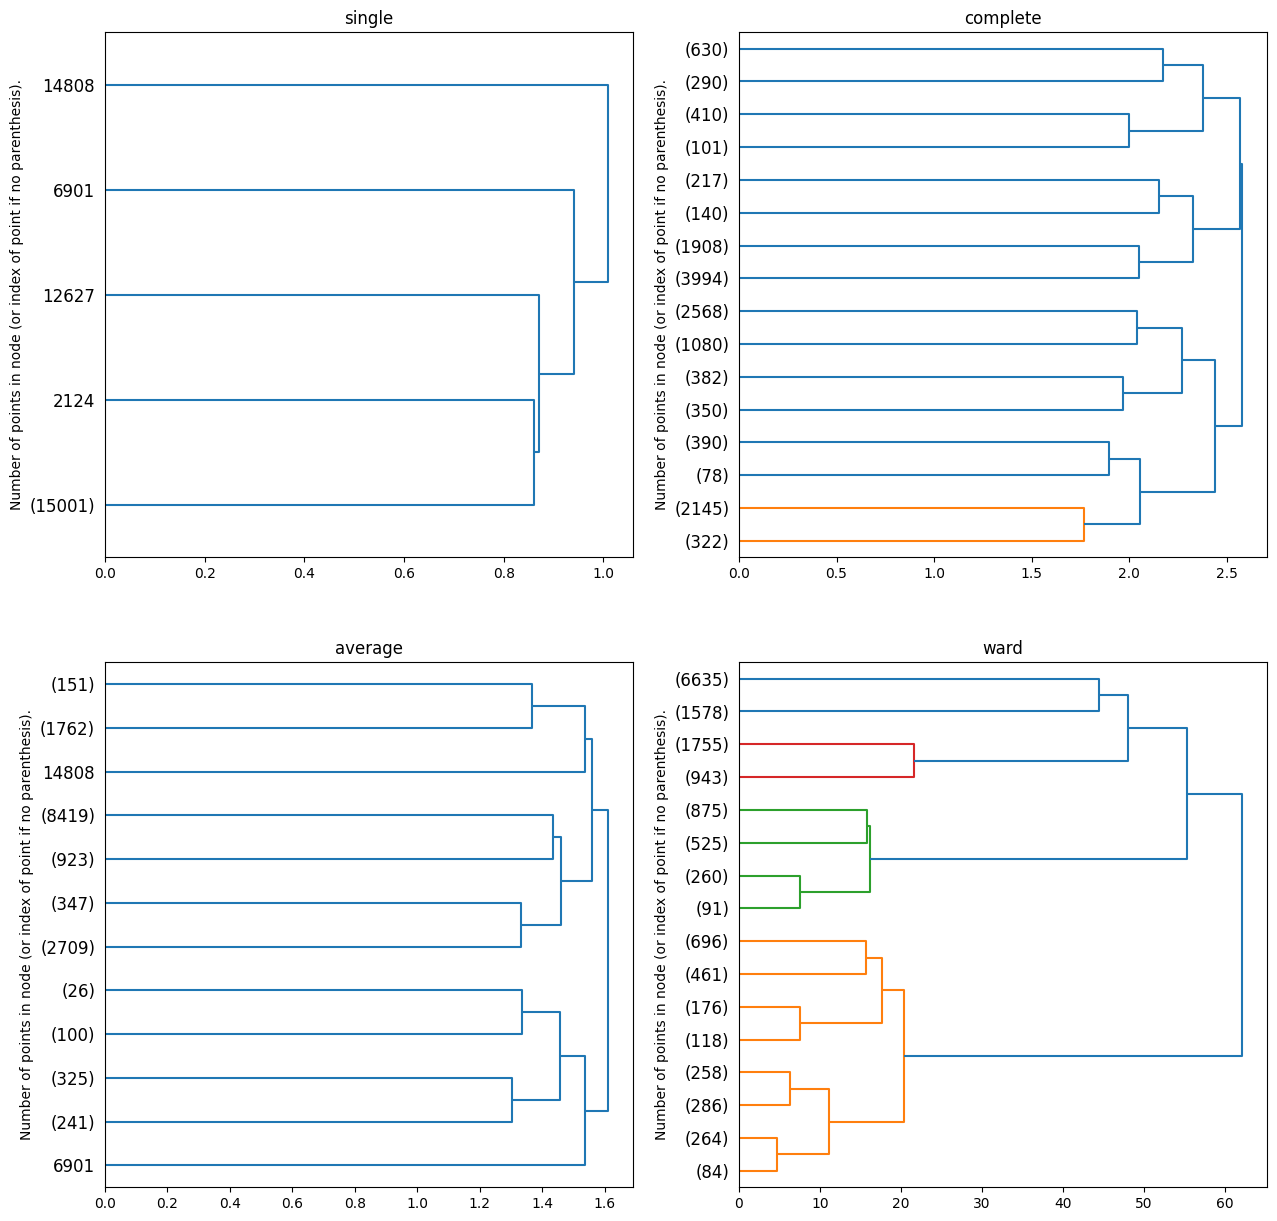

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for i, (linkage, model) in enumerate(zip(linkages, hierarchical_results)):
    # plot the top three levels of the dendrogram
    ax[i // 2][i % 2].set_title(linkage)
    plot_dendrogram(model, truncate_mode="level", p=3, ax=ax[i // 2][i % 2], orientation="right")
    ax[i // 2][i % 2].set_ylabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [27]:
def calculate_sse(labels):
    n_cluster = len(np.unique(labels))
    global_sse = 0
    for i in range(n_cluster): # for each cluster
        cluster_points = scaled_dataset[labels == i]
        centroid = np.mean(cluster_points, axis=0)
        # calculate the sse for the single cluster
        current_sse = 0
        for p in cluster_points:
            current_sse += np.linalg.norm( np.subtract(p, centroid)) ** 2

        global_sse += current_sse
    return global_sse

In [28]:
sse_list = []
silhoutte_list = []
davies_bouldin_list = []

max_k = 20
for k in tqdm(range(2, max_k + 1), ):
    ward_clustering = AgglomerativeClustering(n_clusters=k, linkage="ward")
    ward_clustering.fit(scaled_dataset)

    sse_list.append(calculate_sse(ward_clustering.labels_))
    silhoutte_list.append(silhouette_score(scaled_dataset, ward_clustering.labels_, sample_size=10000))
    davies_bouldin_list.append(davies_bouldin_score(scaled_dataset, ward_clustering.labels_))


100%|██████████| 19/19 [02:34<00:00,  8.14s/it]


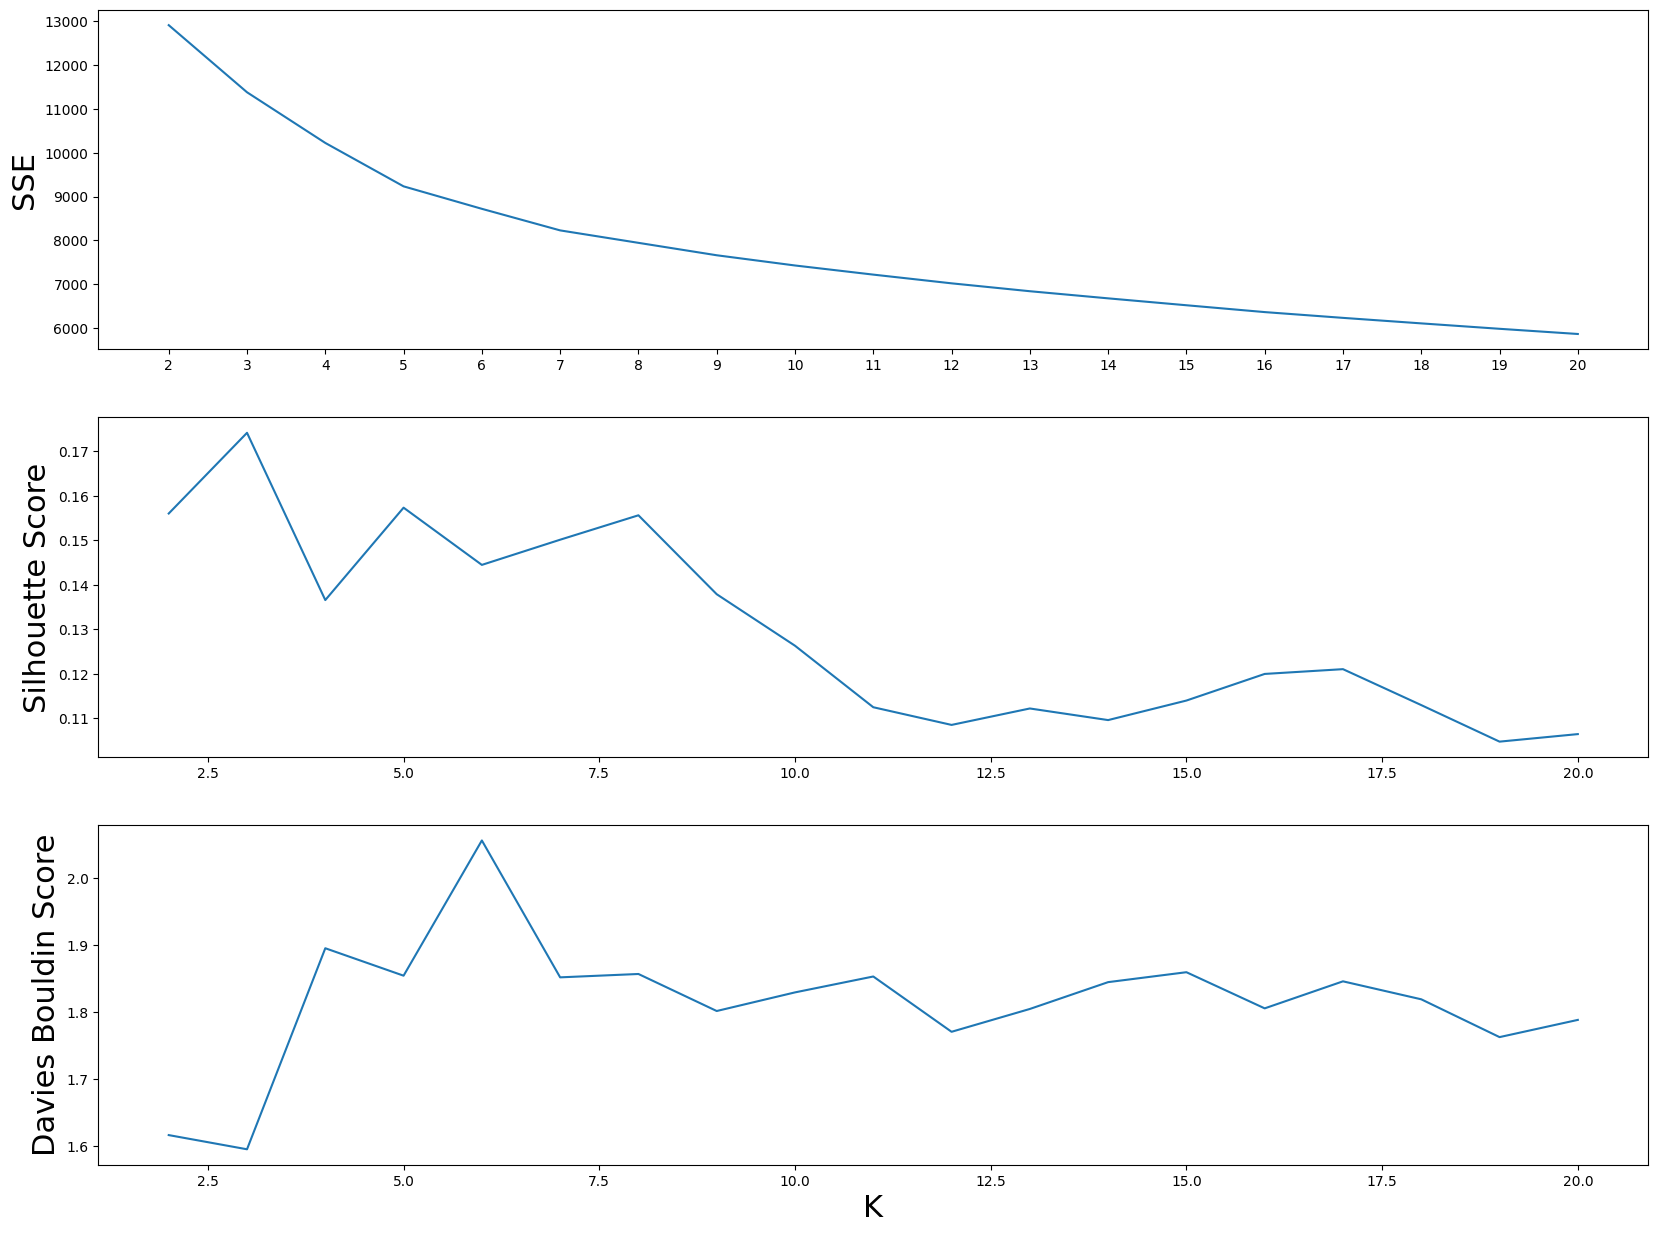

In [29]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list) + 2), sse_list)
ax[0].set_ylabel('SSE', fontsize=22)
ax[0].set_xticks(range(2, len(sse_list) + 2))

ax[1].plot(range(2, len(silhoutte_list) + 2), silhoutte_list)
ax[1].set_ylabel('Silhouette Score', fontsize=22)

ax[2].plot(range(2, len(davies_bouldin_list) + 2), davies_bouldin_list)
ax[2].set_xlabel('K', fontsize=22)
ax[2].set_ylabel('Davies Bouldin Score', fontsize=22)


plt.xlabel('K', fontsize=22)
plt.show()

In [30]:
n_clusters = 8
ward_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
ward_clustering.fit(scaled_dataset)

AgglomerativeClustering(n_clusters=8)

In [31]:
cluster_points = []
for i in range(n_clusters):
    cluster_points.append(scaled_dataset[ward_clustering.labels_ == i])

In [32]:
print('Silhouette %s' % silhouette_score(scaled_dataset, ward_clustering.labels_))
print('Davies-Bouldin %s' % davies_bouldin_score(scaled_dataset, ward_clustering.labels_))

Silhouette 0.1572459138149773
Davies-Bouldin 1.8570905926679138


/home/filippo/uni/DM/DataMiningProject/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/filippo/uni/DM/DataMiningProject/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[]

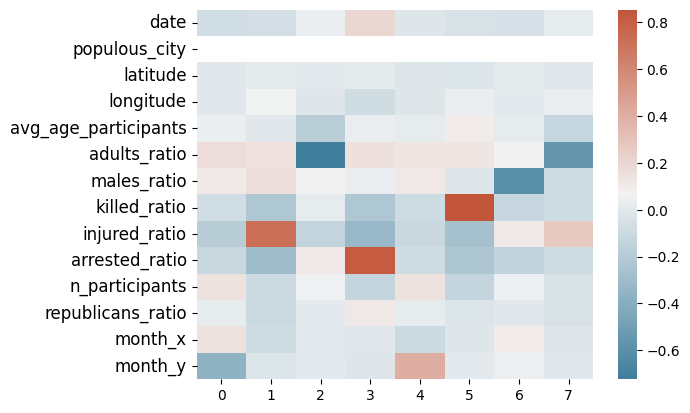

In [33]:
# Transfrom kmeans labels into onehot encoding
onehot = np.zeros((len(ward_clustering.labels_), n_clusters))
onehot[np.arange(len(ward_clustering.labels_)), ward_clustering.labels_] = 1

# Compute correlation between onehot encoding and scaled dataset
onehot_corr = np.corrcoef(scaled_dataset, onehot, rowvar=False)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(onehot_corr[:scaled_dataset.shape[1], scaled_dataset.shape[1]:], fmt = '.2f', cmap=cmap)

# Set ticks on y axis with feature names
plt.yticks(np.arange(scaled_dataset.shape[1]) + 0.5, numeric_dataset.columns, rotation=0, fontsize=12)
[]

([], [])

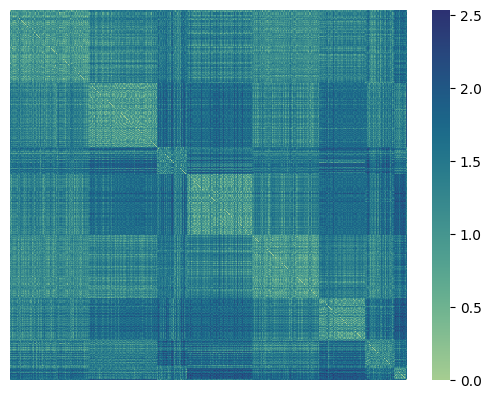

In [34]:
# Downsample the dataset to 10000
samples = np.random.choice(scaled_dataset.shape[0], 1000, replace=False)
downsampled_dataset = scaled_dataset[samples]
downsampled_labels = ward_clustering.labels_[samples]

# Sort based on labels
sorted_indexes = np.argsort(downsampled_labels)
downsampled_dataset = downsampled_dataset[sorted_indexes]
downsampled_labels = downsampled_labels[sorted_indexes]

# Compute similarity matrix
pdist_matrix = squareform(pdist(downsampled_dataset, metric='minkowski', p=2))
sns.heatmap(pdist_matrix, fmt = '.2f', cmap='crest')
plt.xticks([])
plt.yticks([])

In [35]:
tsne = TSNE(n_components=2, n_jobs=-1)
tsne_dataset = tsne.fit_transform(scaled_dataset)

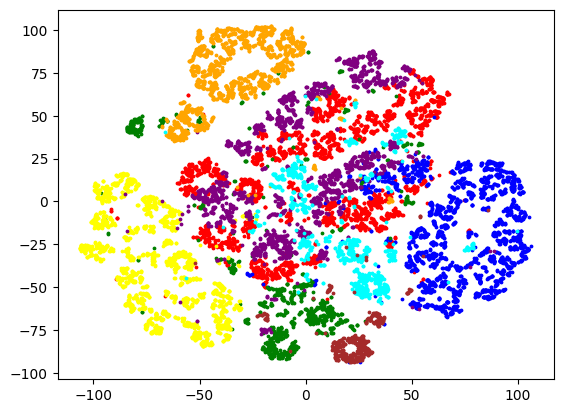

In [36]:
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'brown']
for i in range(n_clusters):
    plt.scatter(tsne_dataset[:,0][ward_clustering.labels_ == i], tsne_dataset[:,1][ward_clustering.labels_ == i], s=3, c=colors[i])
plt.show()

In [37]:
umap_reducer = UMAP().fit(scaled_dataset)


/home/filippo/uni/DM/DataMiningProject/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


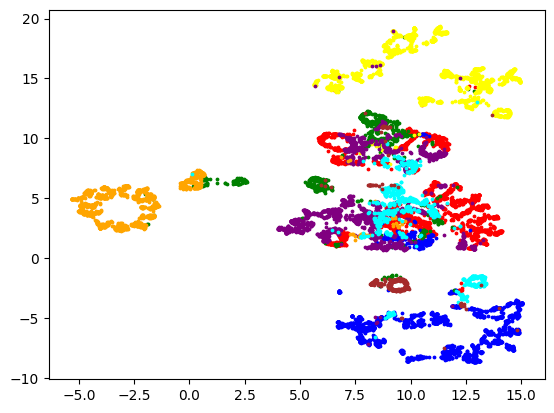

In [38]:
umap_dataset = umap_reducer.transform(scaled_dataset)
for i in range(n_clusters):
    plt.scatter(umap_dataset[:,0][ward_clustering.labels_ == i], umap_dataset[:,1][ward_clustering.labels_ == i], s=3, c=colors[i])
plt.show()

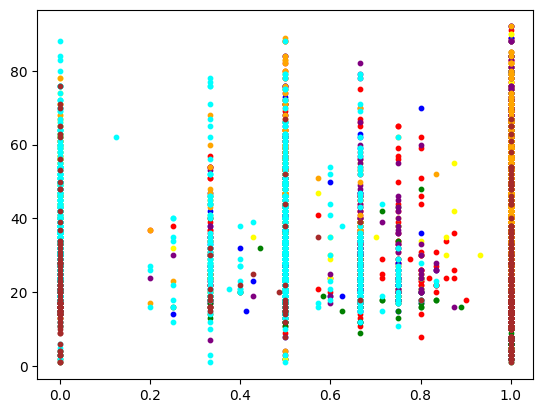

In [44]:
for i in range(n_clusters):
    plt.scatter(numeric_dataset["males_ratio"][ward_clustering.labels_ == i], numeric_dataset["avg_age_participants"][ward_clustering.labels_ == i], c=colors[i], s=10)
plt.show()

In [46]:
party_xt_pct = pd.crosstab(ward_clustering.labels_, numeric_dataset['republicans_ratio'] > 0.5)
party_xt_pct

republicans_ratio,False,True
row_0,,
0,1533,1608
1,1672,1026
2,530,576
3,782,1561
4,1159,1246
5,954,797
6,557,532
7,292,180


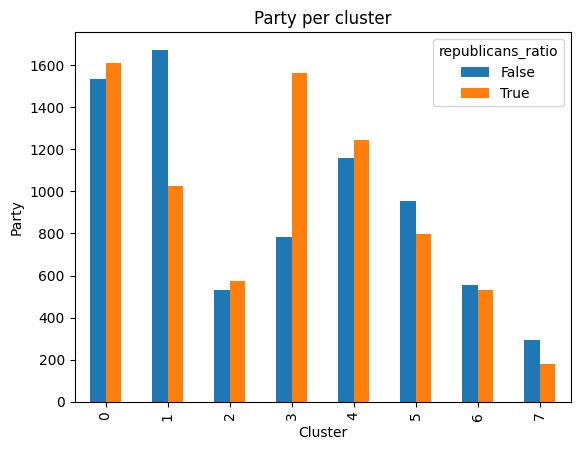

In [47]:
party_xt_pct.plot(kind='bar', stacked=False, 
                   title='Party per cluster')
plt.xlabel('Cluster')
plt.ylabel('Party')
plt.show()

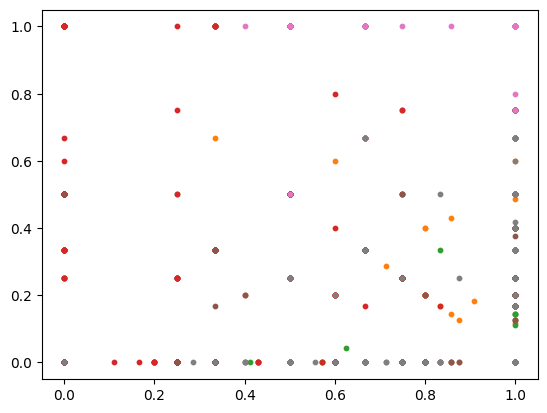

In [51]:
for i in range(n_clusters):
    plt.scatter(numeric_dataset["adults_ratio"][ward_clustering.labels_ == i-1], numeric_dataset["killed_ratio"][ward_clustering.labels_ == i-1], s=10)
plt.show()

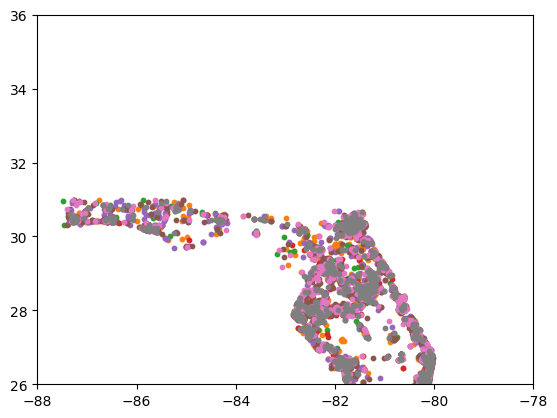

In [52]:
for i in range(n_clusters):
    plt.scatter(numeric_dataset["longitude"][ward_clustering.labels_ == i-1], numeric_dataset["latitude"][ward_clustering.labels_ == i-1], s=10)

plt.xlim(-88, -78)
plt.ylim(26, 36)
plt.show()